In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 데이터셋 불러오기

In [2]:
#https://github.com/tensorflow/datasets/issues/3918#issuecomment-1124730276
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:10000]', 'train[10000:12000]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

### 전처리
- 224x224 크기의 입력 이미지

In [4]:
def preprocess(image, label):
    IMAGE_SIZE = (224,224)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
BATCH_SIZE = 16

# train
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# test
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(buffer_size=tf.data.AUTOTUNE)

### 모델 제작

#### plain34 block

In [6]:
def build_plain34_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer

    # cnn layers
    for num_cnn in range(num_cnns):
        # 블럭의 첫 cnn은 shape을 1/2로 줄임
        # shape 1/2 -> stride=2
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        # batch normalization, activation=relu
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 이하 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation2')(x)

    return x

#### resnet34 block

In [7]:
def build_resnet34_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer
    
    # cnn layers
    for num_cnn in range(num_cnns):
        # 이전 출력값 저장
        x_prev = x
        
        # 블럭의 첫 cnn은 shape을 1/2로 줄임
        if num_cnn ==0 and block_num!=0:
            # shape 1/2 -> stride=2
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
            
            # 이전 출력값
            # 1x1 kernel, stride 2
            x_prev = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_short'
            )(x_prev)
            
            x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)
            

        else:
            # 크기 동일(stride=1)
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        # x와 f(x) Add
        x = keras.layers.Add(name=f'block{block_num}_{num_cnn}_Add')([x,x_prev])
        # 이후 relu
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

    return x

- 참고 이미지  
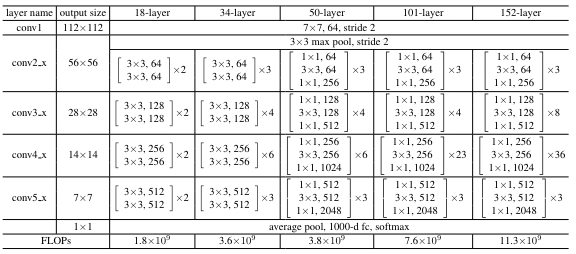

#### plain50 block

In [8]:
def build_plain50_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer

    # cnn layers
    for num_cnn in range(num_cnns):
        # 1번 layer
        # 블럭의 첫 cnn은 shape을 1/2로 줄임 -> strides=2
        # kernel 1x1, filter 동일
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
        
        # 크기 동일(stride=1)
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
        # batch normalization, activation=relu
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 2번 layer
        # kernel 3x3, filter 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

        # 3번 layer
        # kernel 1x1, filter 4배
        x = keras.layers.Conv2D(
            filters = channel*4,
            kernel_size=(1,1),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv3'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN3')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation3')(x)

    return x

#### resnet50 block

In [9]:
def build_resnet50_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer
    
    # cnn layers
    for num_cnn in range(num_cnns):
        # 이전 출력값 저장
        x_prev = x
        
        # 1번 layer
        # 블럭의 첫 cnn은 shape을 1/2로 줄임 -> strides=2
        # kernel 1x1, filter 동일
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
            
            # 이전 출력값
            # 1x1 kernel, stride 2
            x_prev = keras.layers.Conv2D(
                filters = channel*4,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_short'
            )(x_prev)
            
            x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)

        else:
            # 크기 동일(stride=1)
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

            # 첫 블럭 부분
            if num_cnn ==0 and block_num==0:
                x_prev = keras.layers.Conv2D(
                    filters = channel*4,
                    kernel_size=(1,1),
                    activation=None,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_{num_cnn}_short'
                )(x_prev)
                x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)


        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 2번 layer
        # kernel 3x3, filter 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

        # 3번 layer
        # kernel 1x1, filter 4배
        x = keras.layers.Conv2D(
            filters = channel*4,
            kernel_size=(1,1),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv3'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN3')(x)
        
        # x와 f(x) Add
        x = keras.layers.Add(name=f'block{block_num}_{num_cnn}_Add')([x,x_prev])
        # 이후 relu
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation3')(x)

    return x

### 모델

In [10]:
def build_resnet(
    input_shape=(224,224,3),
    num_classes=10,
    is_50=False,
    is_Plain=False
):
    # layers, filters
    num_cnn_list=[3,4,6,3]
    channel_list=[64,128,256,512]

    # input
    input_layer = keras.Input(shape=input_shape)

    # 이미지 참고
    # conv1_x -> kernel 7x7, filter 64, stride 2
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        padding='same',
        name='block0_0_conv'
    )(input_layer)

    output = keras.layers.BatchNormalization(name='block0_0_BN')(output)
    output = keras.layers.Activation(activation='relu', name='block0_0_Activation')(output)
    
    # 이미지 참고
    # conv2_x -> maxpool 3x3, stride 2
    output = keras.layers.MaxPooling2D(
        pool_size=(3,3),
        strides=2,
        padding='same',
        name='block0_0_MaxPooling'
    )(output)

    # 각 block에 들어갈 layer 및 filter 수
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # Plain 모델인 경우,
        if is_Plain:
            if is_50:
                output = build_plain50_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
            else:
                output = build_plain34_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
        # Resnet 모델인 경우,
        else:
            if is_50:
                output = build_resnet50_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
            else:
                output = build_resnet34_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
    
    # 이미지 참고
    # output size 1x1
    output = keras.layers.AveragePooling2D(pool_size=output.shape[-2],padding='same',name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    if num_classes == 1:
        output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000d')(output)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000d')(output)  

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )

    return model

In [11]:
model_plain34 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, is_Plain=True)
model_plain50 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=True, is_Plain=True)
model_resnet34 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, is_Plain=False)
model_resnet50 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=True, is_Plain=False)

In [12]:
model_resnet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block0_0_conv (Conv2D)          (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
block0_0_BN (BatchNormalization (None, 112, 112, 64) 256         block0_0_conv[0][0]              
__________________________________________________________________________________________________
block0_0_Activation (Activation (None, 112, 112, 64) 0           block0_0_BN[0][0]                
____________________________________________________________________________________________

In [13]:
model_plain50.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_0_conv (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
block0_0_BN (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
block0_0_Activation (Activat (None, 112, 112, 64)      0         
_________________________________________________________________
block0_0_MaxPooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
block0_0_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
block0_0_BN1 (BatchNormaliza (None, 56, 56, 64)        256 

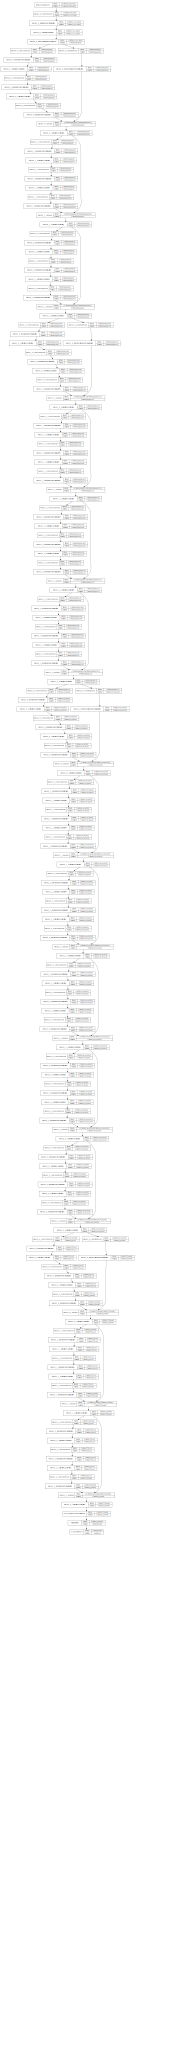

In [14]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Jupyter Notebook에 모델 시각화
SVG(model_to_dot(model_resnet50, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [15]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_resnet50 = model_resnet50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)

Epoch 1/10
294/625 [=============>................] - ETA: 58s - loss: 0.7588 - accuracy: 0.5859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


523/625 [========================>.....] - ETA: 18s - loss: 0.7227 - accuracy: 0.5968

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


550/625 [=========================>....] - ETA: 13s - loss: 0.7209 - accuracy: 0.5961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


556/625 [=========================>....] - ETA: 12s - loss: 0.7199 - accuracy: 0.5969

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.5969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


625/625 [==============================] - 173s 191ms/step - loss: 0.7146 - accuracy: 0.5969 - val_loss: 29.3641 - val_accuracy: 0.5225
Epoch 2/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6549 - accuracy: 0.6245 - val_loss: 4.8007 - val_accuracy: 0.5390
Epoch 3/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6055 - accuracy: 0.6718 - val_loss: 0.6991 - val_accuracy: 0.5495
Epoch 4/10
625/625 [==============================] - 117s 187ms/step - loss: 0.5764 - accuracy: 0.7027 - val_loss: 0.7467 - val_accuracy: 0.6335
Epoch 5/10
625/625 [==============================] - 117s 187ms/step - loss: 0.5573 - accuracy: 0.7237 - val_loss: 3.8257 - val_accuracy: 0.5625
Epoch 6/10
625/625 [==============================] - 117s 187ms/step - loss: 0.5258 - accuracy: 0.7440 - val_loss: 1.4582 - val_accuracy: 0.5420
Epoch 7/10
625/625 [==============================] - 117s 187ms/step - loss: 0.4967 - accuracy: 0.7618 - val_loss: 0.6210 - val_accur

In [ ]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_plain50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_plain50 = model_plain50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)